# *xomx tutorial:* constructing diagnostic biomarker signatures

This is a shorter notebook version of the tutorial [xomx_kidney_classif.md](xomx_kidney_classif.md).
It is is faster to execute, as it starts with preprocessed data, whereas [xomx_kidney_classif.md](xomx_kidney_classif.md) downloads the data from the Cancer Genome Atlas (TGCA) online database. 

**WARNING: this notebook version of the tutorial does not display interactive outputs.**

**For interactive outputs, please follow the standard tutorial: [xomx_kidney_classif.md](xomx_kidney_classif.md).**

The objective of this tutorial is to use a recursive feature elimination method on 
RNA-seq data from the Cancer Genome Atlas (TCGA) to identify gene biomarker signatures 
for the differential diagnosis of three types of kidney cancer: kidney renal clear cell
carcinoma (**KIRC**), kidney renal papillary cell carcinoma (**KIRP**), and chromophobe
renal cell carcinoma (**KICH**).

The recursive feature elimination method is based on 
the [Extra-Trees algorithm](https://link.springer.com/article/10.1007/s10994-006-6226-1)
(and its implementation in 
[scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)).

In [1]:
import xomx
import scanpy as sc
import numpy as np
import os

In [2]:
rng = np.random.RandomState(0)    # Setting the pseudo-random number generator

See [xomx_kidney_classif.md](xomx_kidney_classif.md) for the steps to download data directly from the Cancer Genome Atlas (TCGA) with `gdc-client`, and apply basic normalization and preprocessing.

In this shorter notebook version of the tutorial, we start with the data as it is saved at the end of Step 5 in [xomx_kidney_classif.md](xomx_kidney_classif.md):

In [3]:
xd = sc.read(os.path.join("data", "xomx_k_c_small.h5ad"))

In [4]:
xd

AnnData object with n_obs × n_vars = 465 × 8000
    obs: 'labels'
    var: 'mean_values', 'standard_deviations', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'all_labels', 'hvg', 'obs_indices_per_label', 'test_indices', 'test_indices_per_label', 'train_indices', 'train_indices_per_label', 'var_indices'

`xd` contains the data matrix and the data annotations.
There are 465 samples, and 8000 features which were selected with the function `sc.pp.highly_variable_genes()`, see [xomx_kidney_classif.md](xomx_kidney_classif.md).

`xd.X[0, :]`, the first row, contains the 8000 (normalized and logarithmized) expression levels for the 
first sample.  

In [5]:
xd.X[0, :]

array([0.3750975 , 4.8279443 , 0.71798986, ..., 0.        , 0.38705567,
       0.13106425], dtype=float32)

`xd.X[:, 0]`, the first column, contains the values of the first feature for all samples.

The feature names (gene IDs) are stored in `xd.var_names`, and the sample
identifiers are stored in `xd.obs_names`. 

In [6]:
xd.var_names

Index(['ENSG00000000005.5', 'ENSG00000000971.14', 'ENSG00000001626.13',
       'ENSG00000002079.11', 'ENSG00000002587.8', 'ENSG00000002726.18',
       'ENSG00000002745.11', 'ENSG00000003989.15', 'ENSG00000004399.11',
       'ENSG00000004776.10',
       ...
       'ENSG00000281591.1', 'ENSG00000281655.1', 'ENSG00000281692.1',
       'ENSG00000281769.1', 'ENSG00000281796.1', 'ENSG00000281832.1',
       'ENSG00000281855.1', 'ENSG00000281867.1', 'ENSG00000281881.1',
       'ENSG00000281903.1'],
      dtype='object', length=8000)

The labels are stored in `xd.obs["labels"]`.

In [7]:
xd.obs["labels"]

7afe54c7-6137-4831-8c4c-8642346f84dc    TCGA-KIRC
d29fed52-e98b-4092-b540-8cc693fb2484    TCGA-KIRC
d961989e-f09f-4121-a7e2-b8270e906aab    TCGA-KIRC
52a0e767-d4db-4695-af3b-ec4a16d9fbca    TCGA-KIRC
78247fed-8c1d-4db3-9dd0-c245585de8de    TCGA-KIRC
                                          ...    
504e3dc2-53e8-4f34-a78d-aaa858c87fb4    TCGA-KICH
6f95a152-a3ee-4321-90c1-e61ceef94a80    TCGA-KICH
167ca019-0aea-4d1b-95b7-32c960f70efc    TCGA-KICH
6f3470d9-5b38-4e7c-b4a7-f639905a9060    TCGA-KICH
b0e9aa8e-a575-4efa-a771-9a814fcb955f    TCGA-KICH
Name: labels, Length: 465, dtype: category
Categories (3, object): ['TCGA-KICH', 'TCGA-KIRC', 'TCGA-KIRP']

Using the function `train_and_test_indices()` (see Step 5 in [xomx_kidney_classif.md](xomx_kidney_classif.md)), the data has been divided into a training set and a test set.
- `xd.uns["train_indices"]` is the array of indices of all samples that belong to the training set.
- `xd.uns["test_indices"]`is the array of indices of all samples that belong to the test set.
- `xd.uns["train_indices_per_label"]` is the dictionary of sample indices in the training set, per label. For instance, `xd.uns["train_indices_per_label"]["TCGA-KIRP"]` is the array of indices of all the samples labelled as `"TCGA-KIRP"` that belong to the training set.
- `xd.uns["test_indices_per_label"]`is the dictionary of sample indices in the test set, per label.

In [8]:
xd.uns["test_indices_per_label"]["TCGA-KICH"]

array([445, 429, 443, 462, 434, 433, 431, 440, 426, 463, 422, 402, 411,
       428, 454, 404, 410])

## Training binary classifiers and performing recursive feature elimination

We initialize an empty dictionary of "feature selectors":

In [9]:
feature_selectors = {}

There will be one feature selector per label.
What we call feature selector here is a binary classifier
trained with the Extra-Trees algorithm to
distinguish samples with a given label from
other types of samples. After training, features are
ranked by a measure of importance known as the Gini importance, 
and the 100 most important features are kept. 
Then, the Extra-Trees algorithm is run again on the training
data filtered to the 100 selected features, which leads to a 
new measure of importance of the features. We repeat the 
procedure to progressively select 30, then 20, 15 and finally 10
features. At each iteration, we evaluate on the test set the 
Matthews correlation coefficient (MCC score) of the 
classifier to observe how the performance changes 
when the number of features decreases.  
The progression 100-30-20-15-10 is arbitrary, but 
the most efficient strategies start by aggressively 
reducing the number of features, and then slow down
when the number of features becomes small.

Here is the loop that trains all the classifiers and ends up 
selecting 10 features for every label. It also creates 
`gene_dict`, a dictionary of the 10-gene signatures selected
for each label.

In [10]:
gene_dict = {}
for label in xd.uns["all_labels"]:
    print("Label: " + label)
    feature_selectors[label] = xomx.fs.RFEExtraTrees(
        xd,
        label,
        n_estimators=450,
        random_state=rng,
    )
    feature_selectors[label].init()
    for siz in [100, 30, 20, 15, 10]:
        print("Selecting", siz, "features...")
        feature_selectors[label].select_features(siz)
        print(
            "MCC score:",
            xomx.tl.matthews_coef(feature_selectors[label].confusion_matrix),
        )
    gene_dict[label] = [
        xd.var_names[idx_]
        for idx_ in feature_selectors[label].current_feature_indices
    ]
    print("Done.")

Label: TCGA-KIRC
Selecting 100 features...
MCC score: 0.9004503377814963
Selecting 30 features...
MCC score: 0.9004503377814963
Selecting 20 features...
MCC score: 0.9004503377814963
Selecting 15 features...
MCC score: 0.9004503377814963
Selecting 10 features...
MCC score: 0.9004503377814963
Done.
Label: TCGA-KIRP
Selecting 100 features...
MCC score: 0.9001394041867609
Selecting 30 features...
MCC score: 0.8639184336696986
Selecting 20 features...
MCC score: 0.8639184336696986
Selecting 15 features...
MCC score: 0.8639184336696986
Selecting 10 features...
MCC score: 0.8819305638587349
Done.
Label: TCGA-KICH
Selecting 100 features...
MCC score: 0.8627450980392157
Selecting 30 features...
MCC score: 0.8627450980392157
Selecting 20 features...
MCC score: 0.8627450980392157
Selecting 15 features...
MCC score: 0.8627450980392157
Selecting 10 features...
MCC score: 0.8627450980392157
Done.


## Visualizing results

Using the plotting function `function_scatter()`,
we plot the standard deviation vs mean value for all the 
genes (which were computed before logarithmizing the data).
`function_scatter()` takes in input two functions, one for 
the x-axis, and one for the y-axis. Each of these functions
must take in input the feature index. By changing the 
`obs_or_var` option to "obs" instead of "var", we can use
`function_scatter()` to make a scatter plot over the samples
instead of over the features.

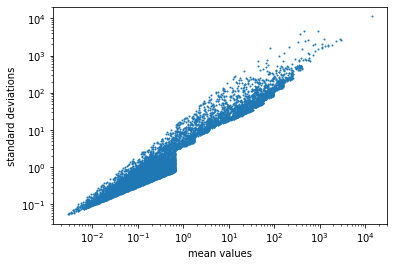

In [11]:
xomx.pl.function_scatter(
    xd,
    lambda idx: xd.var["mean_values"][idx],
    lambda idx: xd.var["standard_deviations"][idx],
    obs_or_var="var",
    xlog_scale=True,
    ylog_scale=True,
    xlabel="mean values",
    ylabel="standard deviations",
)

This plot shows the 8000 highly variable genes selected in Step 5, and we can observe the frontier that was defined by `sc.pp.highly_variable_genes()` to remove genes considered less variable.

**The plot is normally interactive, but by default this is not the case in a notebook.** 

**For interactive outputs, follow the standard version of the tutorial: see [xomx_kidney_classif.md](xomx_kidney_classif.md).**

For a given feature selector, for example `feature_selectors["TCGA-KIRP"]`,
`plot()` displays results on the test set. The classifier uses only the selected 
features, here the 10 features selected for the label `"TCGA-KIRP"`.
Points above the horizontal red line (score > 0.5) are classified as positives (prediction: `"TCGA-KIRP"`), and points below the horizontal line (score < 0.5)
are classified as negatives (prediction: `not "TCGA-KIRP"`).

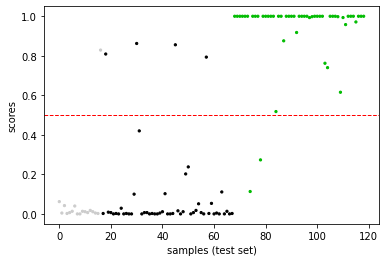

In [12]:
feature_selectors["TCGA-KIRP"].plot()

We can construct a multiclass classifier based on the 3 binary classifiers:

In [13]:
sbm = xomx.cl.ScoreBasedMulticlass(xd, xd.uns["all_labels"], feature_selectors)

This multiclass classifier bases its predictions on 30 features (at most): the 
union of the three 10-gene signatures (one per label). It simply computes the 3 
scores of each of the binary classifiers, and returns the label that corresponds 
to the highest score.  
`plot()` displays results on the test set:

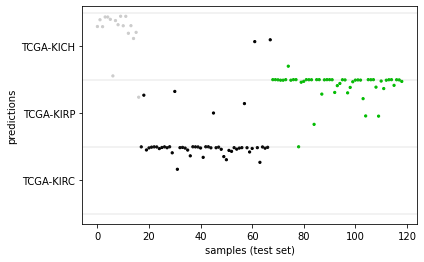

In [14]:
sbm.plot()

For each of the 3 labels, points that are 
higher in the horizontal band correspond to a 
higher confidence in the prediction (but
the very top of the band does not mean 100% 
confidence).

We gather the selected genes in a single list:

In [15]:
all_selected_genes = np.asarray(list(gene_dict.values())).flatten()

We can visualize these marker genes with `xomx.pl.var_plot()`:

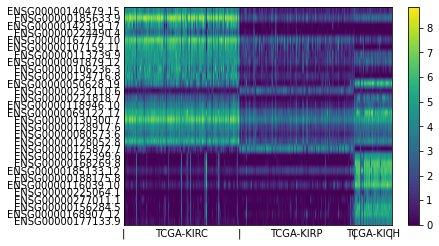

In [16]:
xomx.pl.var_plot(xd, all_selected_genes)

Interestingly, we observe here that, for the label `"TCGA-KIRP"`,
the selected marker genes are mostly downregulated
(which does not mean that upregulated marker genes cannot 
lead to similarly good results).  
Let us zoom on the marker genes for KIRP:

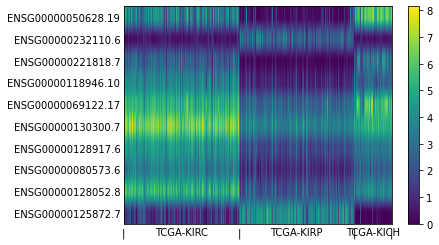

In [17]:
xomx.pl.var_plot(xd, gene_dict["TCGA-KIRP"])

Or, using the Scanpy function `stacked_violin()`:

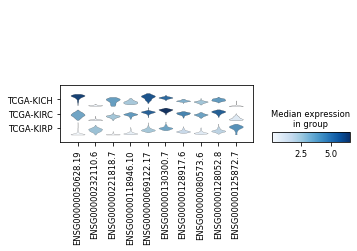

In [18]:
sc.pl.stacked_violin(xd, gene_dict["TCGA-KIRP"], groupby="labels")

We observe at least 2 significantly downregulated genes for KIRP: 
PTGER3 (ENSG00000050628) and EBF2 (ENSG00000221818).

KICH markers:

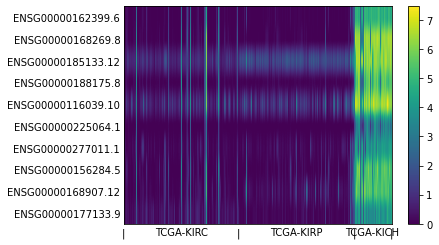

In [19]:
xomx.pl.var_plot(xd, gene_dict["TCGA-KICH"])

We can also use `var_plot()` with a single gene:

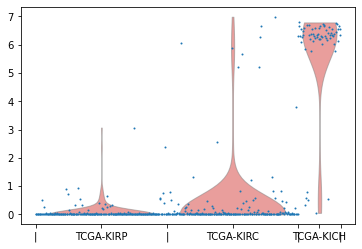

In [20]:
xomx.pl.var_plot(xd, "ENSG00000168269.8")

The FOXI1 (ENSG00000168269) transcription factor is known to 
be drastically overexpressed in KICH. In fact, it has been argued that 
the FOXI1-driven transcriptome that defines renal intercalated cells is retained 
in KICH and implicates the intercalated cell type as the cell of origin 
for KICH; see: 
**[D. Lindgren et al., *Cell-Type-Specific Gene Programs of the Normal Human 
Nephron Define Kidney Cancer Subtypes*, Cell Reports 2017 Aug; 20(6): 1476-1489. 
doi: [10.1016/j.celrep.2017.07.043](
https://doi.org/10.1016/j.celrep.2017.07.043
)]**

KIRC markers:

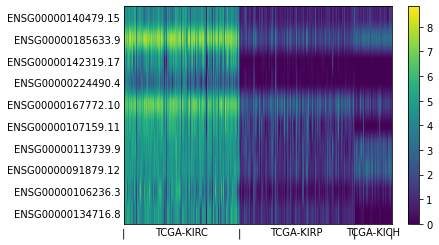

In [21]:
xomx.pl.var_plot(xd, gene_dict["TCGA-KIRC"])

We can notice in particular the upregulation of NDUFA4L2 (ENSG00000185633),
a gene that has been analyzed as a biomarker for KIRC in
**[D. R. Minton et al., *Role of NADH Dehydrogenase (Ubiquinone) 1 alpha subcomplex 4-like 
2 in clear cell renal cell carcinoma*, 
Clin Cancer Res. 2016 Jun 1;22(11):2791-801. doi: [10.1158/1078-0432.CCR-15-1511](
https://doi.org/10.1158/1078-0432.CCR-15-1511
)]**.

Finally, we filter and restrict the data to the selected genes, and follow 
the Scanpy procedure to compute a 2D UMAP embedding:

In [22]:
xd = xd[:, all_selected_genes]
xd.var_names_make_unique()
sc.pp.neighbors(xd, n_neighbors=10, n_pcs=40, random_state=rng)
sc.tl.umap(xd, random_state=rng)

`sc.tl.umap()` stores the embedding in `xd.obsm["X_umap"]`.  
We use `xomx.pl.plot2d()` to display an interactive plot:

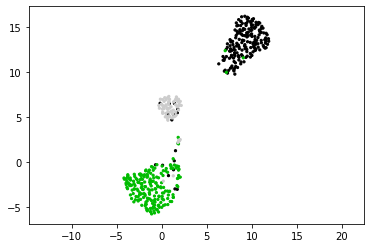

In [24]:
xomx.pl.plot2d(xd, "X_umap")